In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import VarianceThreshold
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM, Convolution1D, GlobalMaxPooling1D
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from matplotlib import pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

import seaborn as sns
# Word2vec
import gensim

# Utility
import ssl
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

In [2]:
df = pd.read_csv('d1.csv')
print(df.iloc[:10])

   Unnamed: 0                                            message  label
0           0  The lack of this understanding is a small but ...      1
1           1  i just told my parents about my depression and...      1
2           2  depression is something i don't speak about ev...      1
3           3  Made myself a tortilla filled with pb&j. My de...      1
4           4  @WorldofOutlaws I am gonna need depression med...      1
5           5  my anxiety and my depression fighting over who...      1
6           6  wow she's suddenly cured my depression and gav...      1
7           7  I am officially done with @kanyewest. him, the...      1
8           8  Me: what's wrong?My girl: *looks up at me with...      1
9           9  @AusBorderForce @PeterDutton_MP @shanebazzi Ag...      1


In [3]:
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
    
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/santhosh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [5]:
def preprocess(text, stem=True):
    # Remove link,user and special characters
    TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [6]:
print(df.head())
df.message = df.message.apply(lambda x: preprocess(x))

print("after preprocessing")
print(df.head())

   Unnamed: 0                                            message  label
0           0  The lack of this understanding is a small but ...      1
1           1  i just told my parents about my depression and...      1
2           2  depression is something i don't speak about ev...      1
3           3  Made myself a tortilla filled with pb&j. My de...      1
4           4  @WorldofOutlaws I am gonna need depression med...      1
after preprocessing
   Unnamed: 0                                            message  label
0           0  lack understand small signific part caus anxie...      1
1           1  told parent depress hard get gen x peopl under...      1
2           2  depress someth speak even go also doubl edg sw...      1
3           3  made tortilla fill pb j depress cure olivia 1 ...      1
4           4  gonna need depress med soon rainout spin equil...      1


In [7]:
texts = df.message.to_numpy()
labels = df.label.to_numpy()

In [11]:
# Initialize TF-IDF vectorizer with maximum features set to 1000
vectorizer = TfidfVectorizer(max_features=1000)

# Fit and transform the texts into TF-IDF features
tfidf_features = vectorizer.fit_transform(texts)

# Set the maximum sequence length to the number of features in the TF-IDF matrix
max_len = tfidf_features.shape[1]

# Split the dataset into train and test sets


In [9]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, labels, test_size=0.2, random_state=42)

In [12]:
tfidf_features.shape[1]

1000

**LSTM**

In [46]:
# Build the LSTM model
model = Sequential()
model.add(Embedding(input_dim=tfidf_features.shape[1], output_dim=128, input_length=max_len, mask_zero=True))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [48]:
# Train the LSTM model
model.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/10
51/51 [==============================] - 167s 3s/step - loss: 0.6037 - accuracy: 0.6312 - val_loss: 0.5615 - val_accuracy: 0.6836
Epoch 2/10
51/51 [==============================] - 281s 6s/step - loss: 0.5742 - accuracy: 0.6741 - val_loss: 0.5649 - val_accuracy: 0.6652
Epoch 3/10
51/51 [==============================] - 375s 7s/step - loss: 0.5696 - accuracy: 0.6766 - val_loss: 0.5598 - val_accuracy: 0.6836
Epoch 4/10
51/51 [==============================] - 207s 4s/step - loss: 0.5696 - accuracy: 0.6709 - val_loss: 0.5627 - val_accuracy: 0.6836
Epoch 5/10
51/51 [==============================] - 398s 8s/step - loss: 0.5695 - accuracy: 0.6731 - val_loss: 0.5612 - val_accuracy: 0.6652
Epoch 6/10
51/51 [==============================] - 192s 4s/step - loss: 0.5694 - accuracy: 0.6737 - val_loss: 0.5643 - val_accuracy: 0.6652
Epoch 7/10
51/51 [==============================] - 182s 4s/step - loss: 0.5678 - accuracy: 0.6772 - val_loss: 0.5619 - val_accuracy: 0.6652
Epoch 8/10
51

In [50]:
# Evaluate the LSTM model
loss, accuracy = model.evaluate(X_test, y_test, batch_size=1)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

1631/1631 [==============================] - 79s 49ms/step - loss: 0.5626 - accuracy: 0.6652
Test Loss: 0.5625651478767395
Test Accuracy: 0.6652360558509827


In [54]:
y_train = y_train.reshape(-1,1)
y_train

array([[1],
       [1],
       [0],
       ...,
       [1],
       [0],
       [0]])

In [55]:
labels_pred = model.predict(X_test)
labels_pred = np.round(labels_pred)
print(classification_report(y_test, labels_pred))

51/51 [==============================] - 19s 375ms/step
              precision    recall  f1-score   support

           0       0.56      0.77      0.65       649
           1       0.80      0.60      0.68       982

    accuracy                           0.67      1631
   macro avg       0.68      0.68      0.66      1631
weighted avg       0.70      0.67      0.67      1631



In [56]:
report = classification_report(y_test, labels_pred, output_dict=True)
data = [['precision', report['1']['precision']], ['recall', report['1']['recall']], ['accuracy', report['accuracy']], ['f1-score', report['1']['f1-score']]]
df_lstm = pd.DataFrame(data, columns=['cat', 'val'])
df_lstm['source'] = 'lstm'
df_lstm.head()

,cat,val,source
0,precision,0.796196,lstm
1,recall,0.596741,lstm
2,accuracy,0.665236,lstm
3,f1-score,0.682189,lstm


In [57]:
def predict(text):
    TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            tokens.append(stemmer.stem(token))
    text = " ".join(tokens)
    text = np.array([text])
    text = vectorizer.transform(text)
    return "POSITIVE" if model.predict(text.toarray()) > 0.5 else "NEGATIVE"

In [58]:
predict("depression is real, life is very hard, i hate everything, suicide is only way")

1/1 [==============================] - 1s 1s/step


'POSITIVE'

In [59]:
predict("i enjoyed the vacations, i loved listening to songs when i was in vacation")

1/1 [==============================] - 0s 60ms/step


'NEGATIVE'

CNN

In [60]:
# Build the CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(tfidf_features.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
X_train_reshaped = X_train.toarray().reshape(X_train.shape[0], tfidf_features.shape[1], 1)
X_test_reshaped = X_test.toarray().reshape(X_test.shape[0], tfidf_features.shape[1], 1)

In [62]:
model.fit(X_train_reshaped, y_train, epochs=10, batch_size=1, validation_data=(X_test_reshaped, y_test))


Epoch 1/10
6524/6524 [==============================] - 25s 4ms/step - loss: 0.3215 - accuracy: 0.8533 - val_loss: 0.1964 - val_accuracy: 0.9154
Epoch 2/10
6524/6524 [==============================] - 24s 4ms/step - loss: 0.1491 - accuracy: 0.9439 - val_loss: 0.1337 - val_accuracy: 0.9448
Epoch 3/10
6524/6524 [==============================] - 24s 4ms/step - loss: 0.1337 - accuracy: 0.9526 - val_loss: 0.2207 - val_accuracy: 0.9191
Epoch 4/10
6524/6524 [==============================] - 24s 4ms/step - loss: 0.1285 - accuracy: 0.9540 - val_loss: 0.1298 - val_accuracy: 0.9491
Epoch 5/10
6524/6524 [==============================] - 24s 4ms/step - loss: 0.1222 - accuracy: 0.9532 - val_loss: 0.1158 - val_accuracy: 0.9534
Epoch 6/10
6524/6524 [==============================] - 26s 4ms/step - loss: 0.1208 - accuracy: 0.9555 - val_loss: 0.1253 - val_accuracy: 0.9510
Epoch 7/10
6524/6524 [==============================] - 25s 4ms/step - loss: 0.1162 - accuracy: 0.9554 - val_loss: 0.1364 - val_ac

In [63]:
labels_pred = model.predict(X_test_reshaped)
labels_pred = np.round(labels_pred.flatten())
print(classification_report(y_test, labels_pred))

51/51 [==============================] - 1s 16ms/step
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       649
           1       0.95      0.98      0.96       982

    accuracy                           0.95      1631
   macro avg       0.96      0.95      0.95      1631
weighted avg       0.95      0.95      0.95      1631



In [67]:
report = classification_report(y_test, labels_pred, output_dict=True)
data = [['precision', report['1']['precision']], ['recall', report['1']['recall']], ['accuracy', report['accuracy']], ['f1-score', report['1']['f1-score']]]
df_cnn = pd.DataFrame(data, columns=['cat', 'val'])
df_cnn['source'] = 'cnn'
df_cnn.head()

,cat,val,source
0,precision,0.947680,cnn
1,recall,0.977597,cnn
2,accuracy,0.954016,cnn
3,f1-score,0.962406,cnn


**Hybrid**


In [35]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(tfidf_features.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [36]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 998, 64)           256       
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 499, 64)          0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 497, 128)          24704     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 248, 128)         0         
 1D)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dense_3 (Dense)             (None, 1)                

In [38]:
model.fit(X_train_reshaped, y_train, epochs=10, batch_size=1, validation_data=(X_test_reshaped, y_test))


Epoch 1/10
6524/6524 [==============================] - 277s 42ms/step - loss: 0.6878 - accuracy: 0.5587 - val_loss: 0.6703 - val_accuracy: 0.6058
Epoch 2/10
6524/6524 [==============================] - 270s 41ms/step - loss: 0.6856 - accuracy: 0.5647 - val_loss: 0.6715 - val_accuracy: 0.6101
Epoch 3/10
6524/6524 [==============================] - 270s 41ms/step - loss: 0.6824 - accuracy: 0.5737 - val_loss: 0.6724 - val_accuracy: 0.6162
Epoch 4/10
6524/6524 [==============================] - 270s 41ms/step - loss: 0.6756 - accuracy: 0.5799 - val_loss: 0.6685 - val_accuracy: 0.6174
Epoch 5/10
6524/6524 [==============================] - 270s 41ms/step - loss: 0.6658 - accuracy: 0.5826 - val_loss: 0.6598 - val_accuracy: 0.6205
Epoch 6/10
6524/6524 [==============================] - 270s 41ms/step - loss: 0.6699 - accuracy: 0.5823 - val_loss: 0.6699 - val_accuracy: 0.6033
Epoch 7/10
6524/6524 [==============================] - 273s 42ms/step - loss: 0.6670 - accuracy: 0.5972 - val_loss: 0

In [43]:
labels_pred = model.predict(X_test_reshaped)
labels_pred = np.round(labels_pred.flatten())
print(classification_report(y_test, labels_pred))
report = classification_report(y_test, labels_pred, output_dict=True)

51/51 [==============================] - 4s 78ms/step
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       649
           1       0.95      0.92      0.93       982

    accuracy                           0.92      1631
   macro avg       0.91      0.92      0.92      1631
weighted avg       0.92      0.92      0.92      1631



In [69]:
data = [['precision', report['1']['precision']], ['recall', report['1']['recall']], ['accuracy', report['accuracy']], ['f1-score', report['1']['f1-score']]]
df_hybrid = pd.DataFrame(data, columns=['cat', 'val'])
df_hybrid['source'] = 'hybrid'
df_hybrid.head()

,cat,val,source
0,precision,0.947680,hybrid
1,recall,0.977597,hybrid
2,accuracy,0.954016,hybrid
3,f1-score,0.962406,hybrid


In [70]:
df_tfidf = pd.concat([df_lstm, df_cnn, df_hybrid])
df_tfidf

,cat,val,source
0,precision,0.796196,lstm
1,recall,0.596741,lstm
2,accuracy,0.665236,lstm
3,f1-score,0.682189,lstm
0,precision,0.947680,cnn
1,recall,0.977597,cnn
2,accuracy,0.954016,cnn
3,f1-score,0.962406,cnn
0,precision,0.947680,hybrid
1,recall,0.977597,hybrid


Text(0.5, 1.0, 'TC_tfidf')

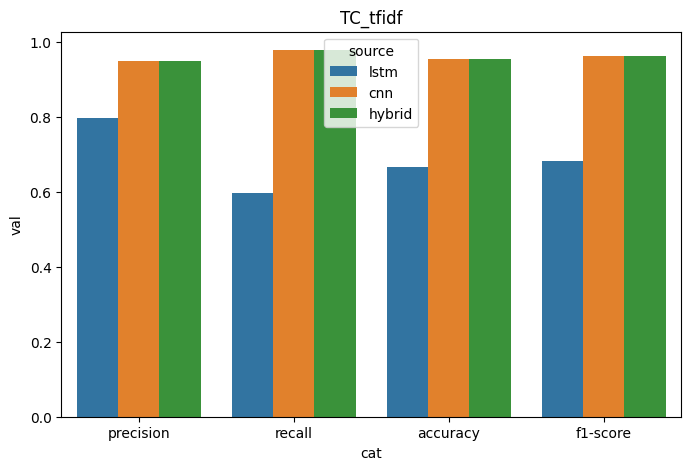

In [73]:
plt.figure(figsize=(8,5))
sns.barplot(x ='cat', y = 'val', data=df_tfidf, hue='source')
plt.title("TC_tfidf")